In [ ]:
# ----------------------------------------
# Imports
# ----------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os



In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV # Import GridSearchCV here
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,  mean_squared_error # Import mean_squared_error

from prophet import Prophet

In [ ]:
# ----------------------------------------
# Load and Preprocess Dataset
# ----------------------------------------
air_quality_data = pd.read_csv("/content/AirQualityUCI.csv")
air_quality_data = air_quality_data.iloc[:, :-2]
air_quality_data = air_quality_data.head(9357)
air_quality_data = air_quality_data.replace(to_replace=-200, value=np.nan)


In [ ]:
# Fill missing values
numerical_columns = air_quality_data.select_dtypes(include=np.number).columns
air_quality_data[numerical_columns] = air_quality_data[numerical_columns].fillna(air_quality_data[numerical_columns].mean())

In [ ]:
# ----------------------------------------
# Prophet Forecasting (Optional)
# ----------------------------------------
date_info = pd.to_datetime(air_quality_data['Date'], format='%m/%d/%Y')
time_info = pd.to_datetime(air_quality_data['Time'], format='%H:%M:%S').dt.time
date_time = pd.to_datetime(date_info.astype(str) + ' ' + time_info.astype(str))

In [ ]:
data = pd.DataFrame({'ds': date_time, 'y': air_quality_data['CO(GT)']})
model = Prophet()
model.fit(data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9yme1rjl/w_9iwvl6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9yme1rjl/32993bu0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34987', 'data', 'file=/tmp/tmp9yme1rjl/w_9iwvl6.json', 'init=/tmp/tmp9yme1rjl/32993bu0.json', 'output', 'file=/tmp/tmp9yme1rjl/prophet_modelwl77hcv8/prophet_model-20250513044446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:44:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:44:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=365, freq="H")
forecast = model.predict(future)

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


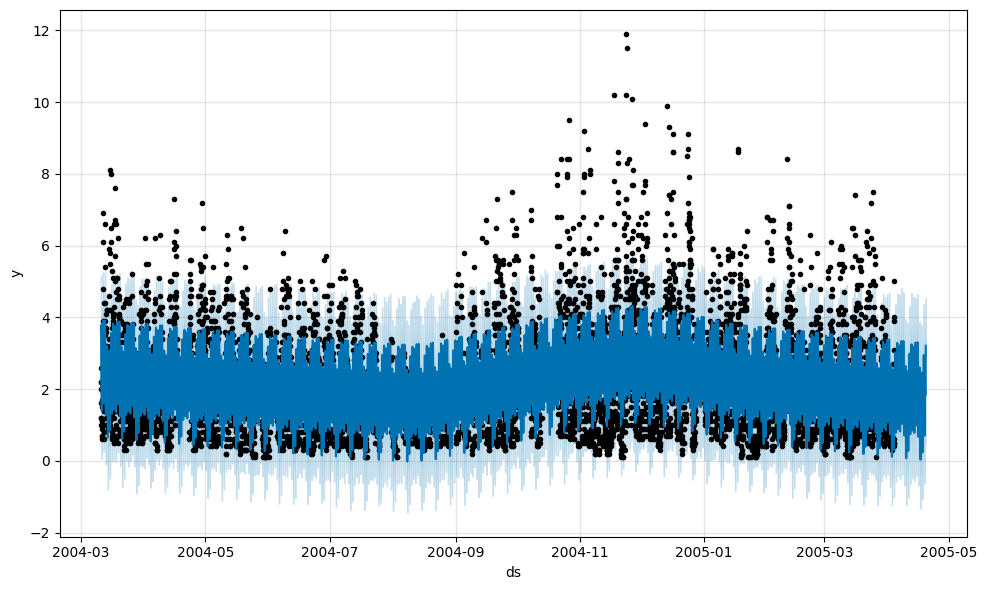

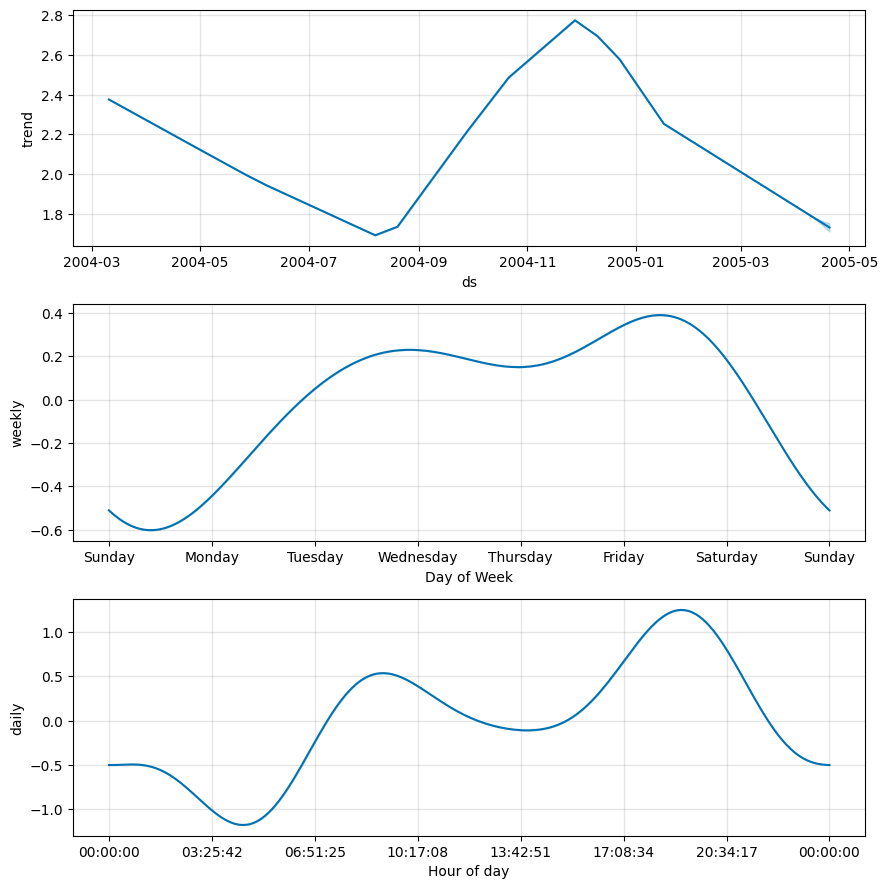

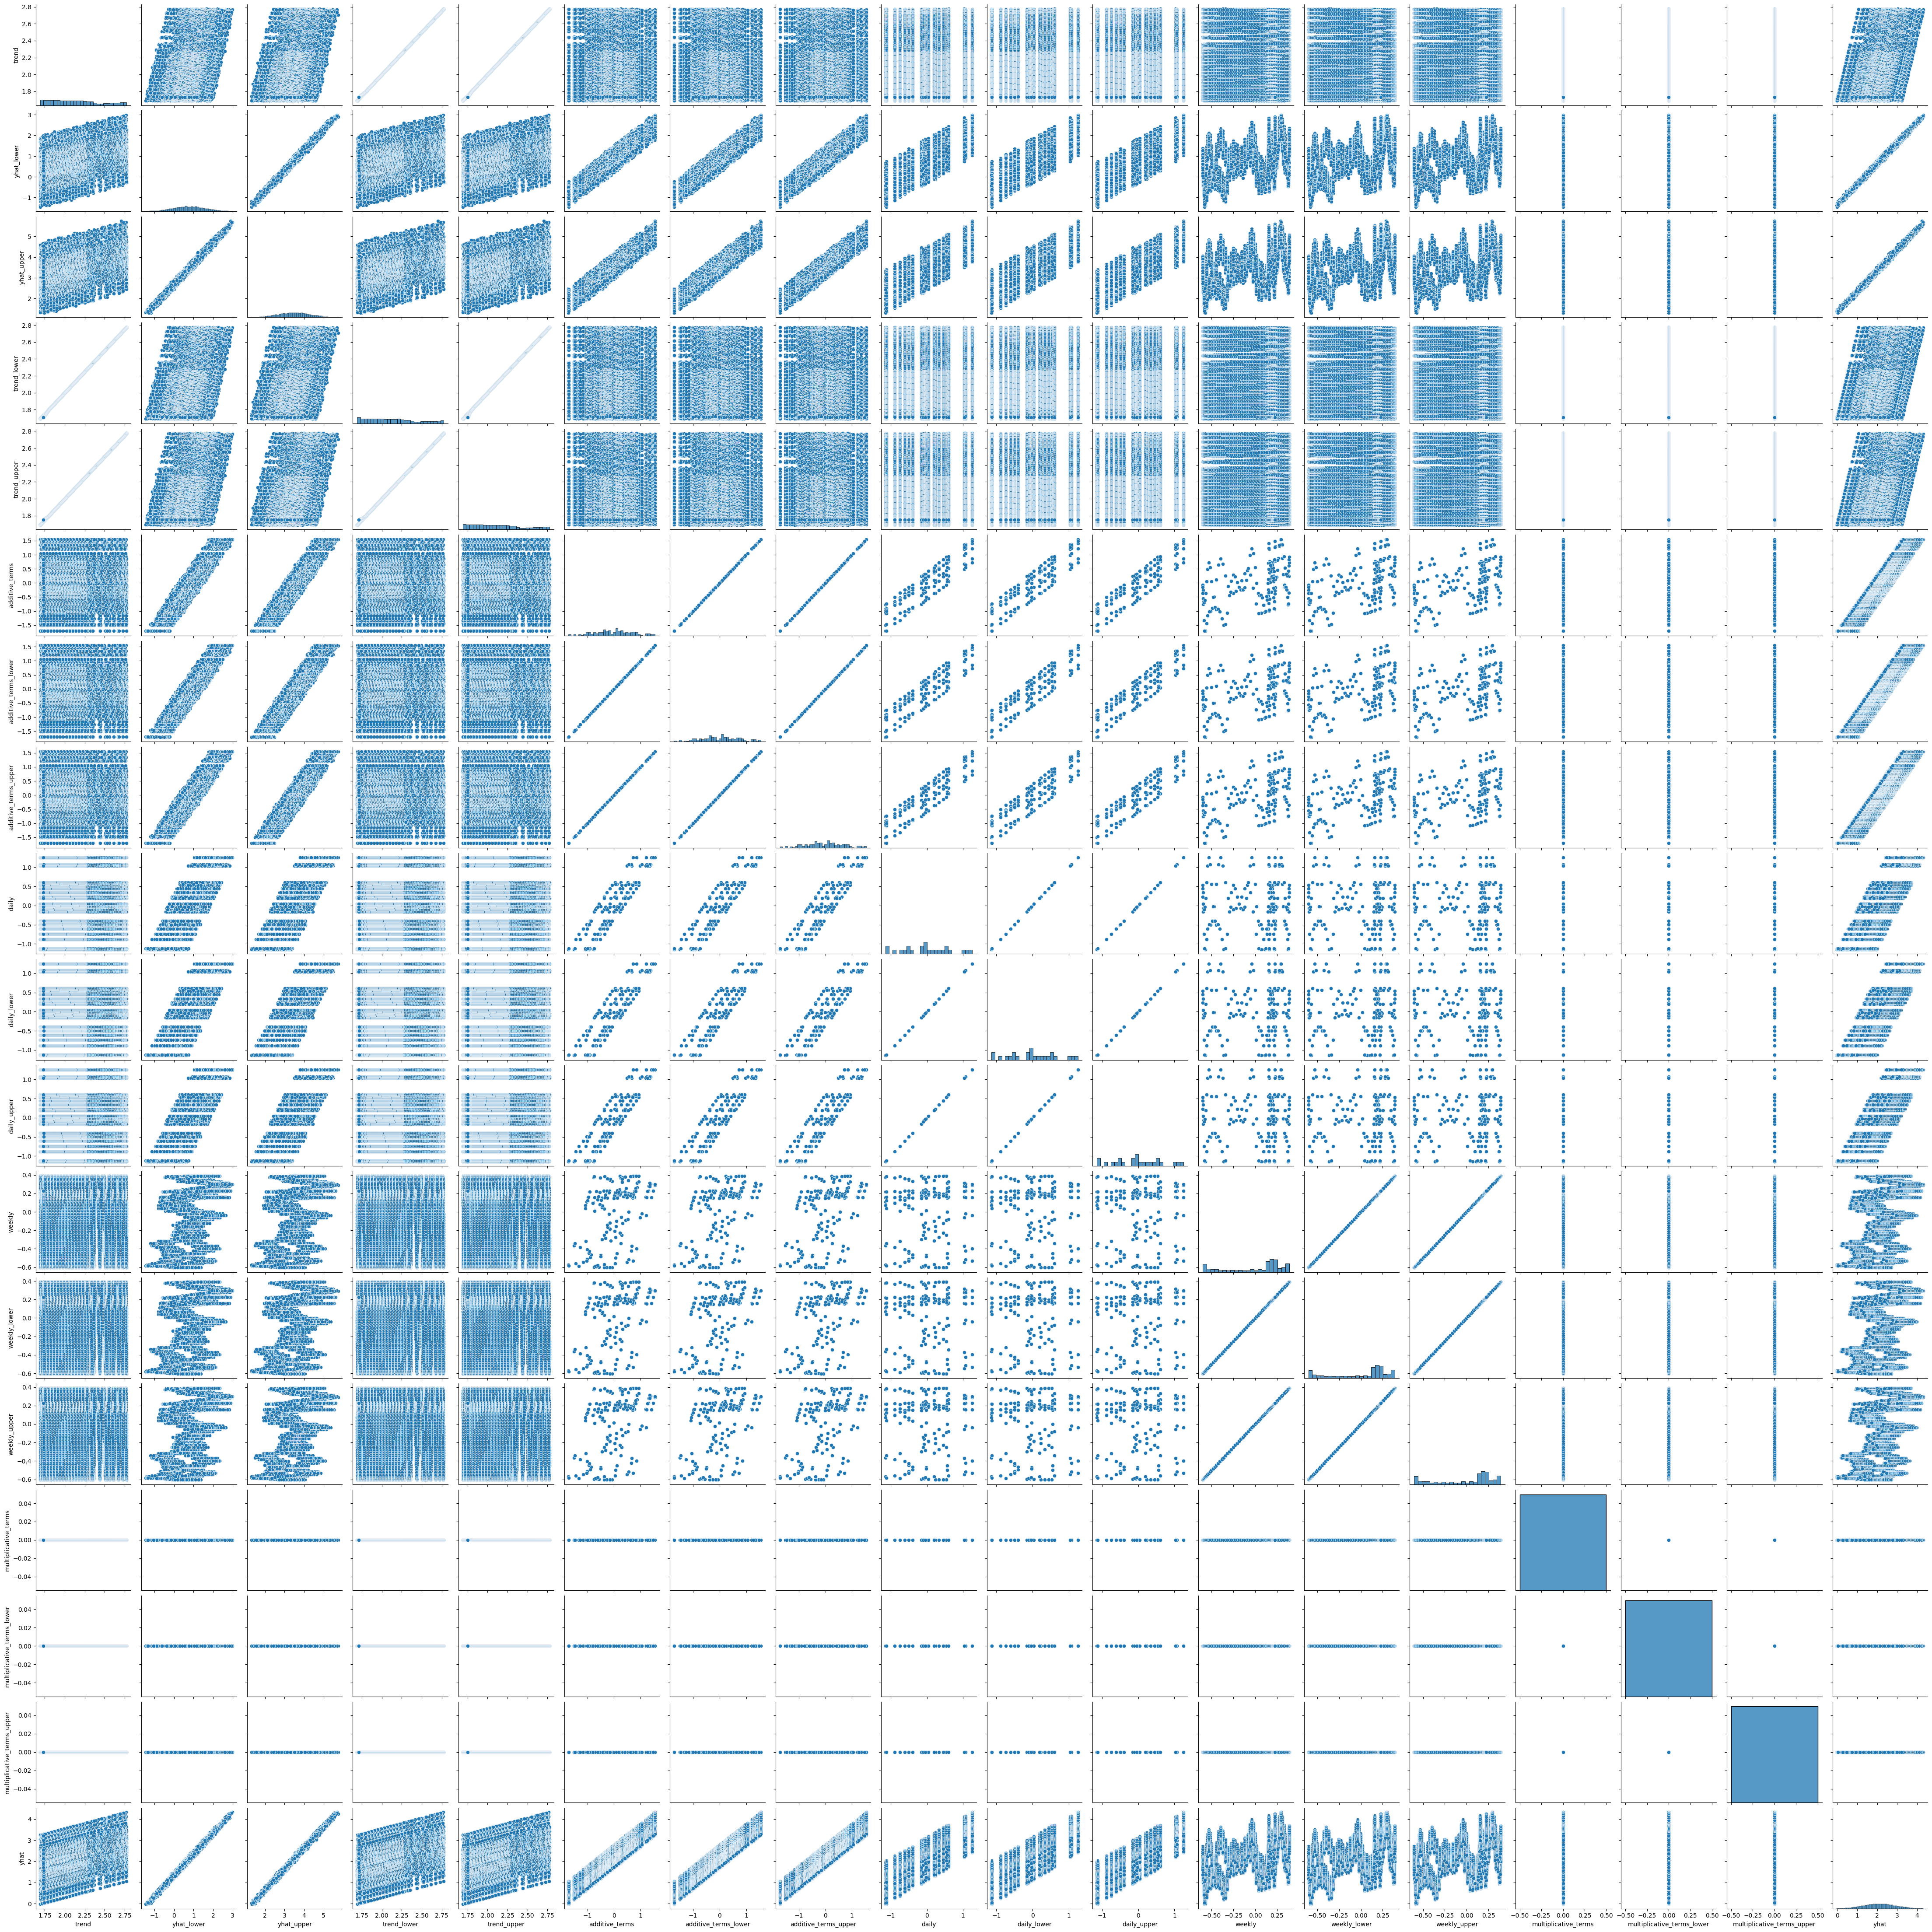

In [ ]:
# Optional visualization
model.plot(forecast)
model.plot_components(forecast)
sns.pairplot(forecast)

In [ ]:
# Feature Engineering
data['year'] = data['ds'].dt.year
data['month'] = data['ds'].dt.month
data['day'] = data['ds'].dt.day
data['hour'] = data['ds'].dt.hour
data['weekday'] = data['ds'].dt.weekday

In [ ]:
features = ['year', 'month', 'day', 'hour', 'weekday']
X = data[features]
y = data['y']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [ ]:
print("\nLinear Regression Results:")
print("MSE:", mean_squared_error(y_test, y_pred_lr))
print("R2 Score:", r2_score(y_test, y_pred_lr))


Linear Regression Results:
MSE: 1.578814355342737
R2 Score: 0.1496038997685234


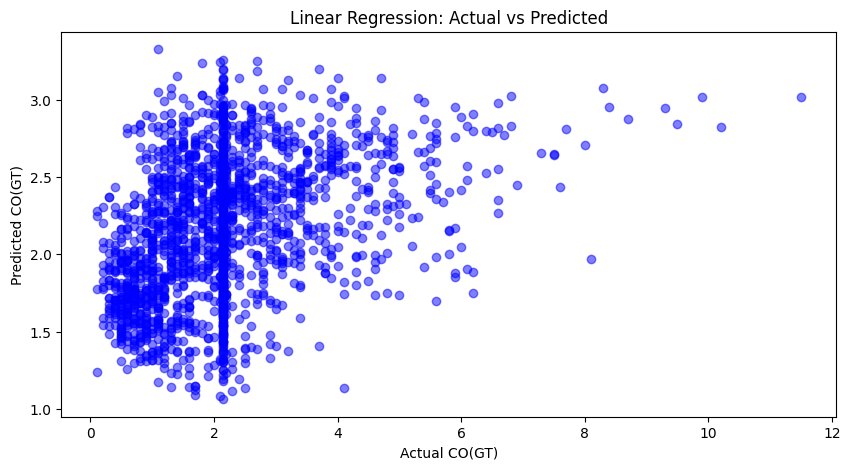

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred_lr, color='blue', alpha=0.5)
plt.xlabel("Actual CO(GT)")
plt.ylabel("Predicted CO(GT)")
plt.title("Linear Regression: Actual vs Predicted")
plt.show()

In [ ]:
# Decision Tree
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

In [ ]:
print("\nDecision Tree Regression Results:")
print("MSE:", mean_squared_error(y_test, y_pred_dt))
print("R2 Score:", r2_score(y_test, y_pred_dt))


Decision Tree Regression Results:
MSE: 0.7604342468171575
R2 Score: 0.5904076272251855


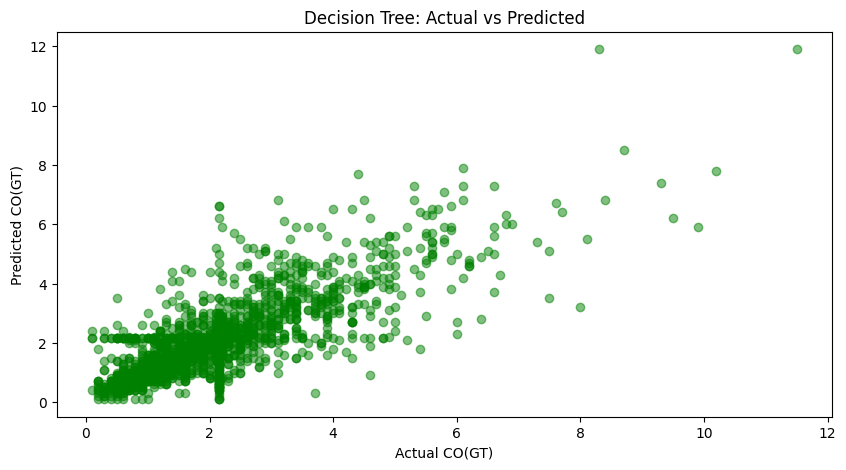

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred_dt, color='green', alpha=0.5)
plt.xlabel("Actual CO(GT)")
plt.ylabel("Predicted CO(GT)")
plt.title("Decision Tree: Actual vs Predicted")
plt.show()

In [ ]:
# Tuning Decision Tree
param_grid = {
    'max_depth': [3, 5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

In [ ]:
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
print("\nBest Parameters for Decision Tree:", grid_search.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits

Best Parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [ ]:
best_dt_model = grid_search.best_estimator_
y_pred_best_dt = best_dt_model.predict(X_test)

In [ ]:
print("\nTuned Decision Tree Results:")
print("MSE:", mean_squared_error(y_test, y_pred_best_dt))
print("R2 Score:", r2_score(y_test, y_pred_best_dt))


Tuned Decision Tree Results:
MSE: 0.796765124557218
R2 Score: 0.5708387421035227


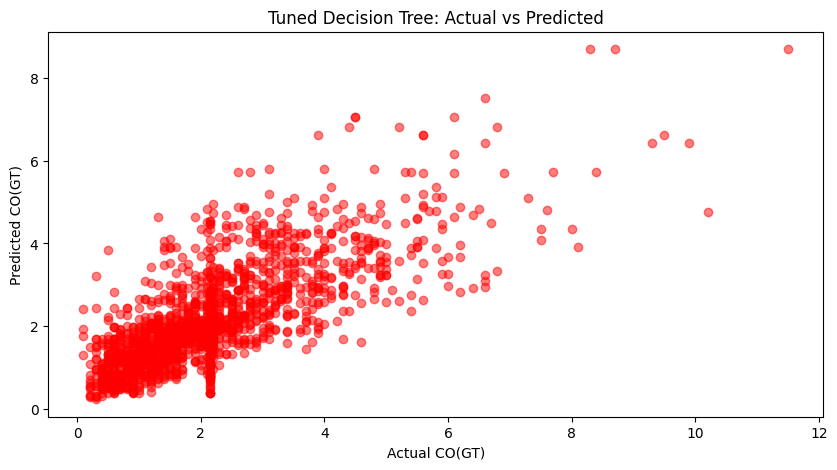

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred_best_dt, color='red', alpha=0.5)
plt.xlabel("Actual CO(GT)")
plt.ylabel("Predicted CO(GT)")
plt.title("Tuned Decision Tree: Actual vs Predicted")
plt.show()

In [ ]:
# Feature Importance
importances = best_dt_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

<ipython-input-25-30c3ab92438e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


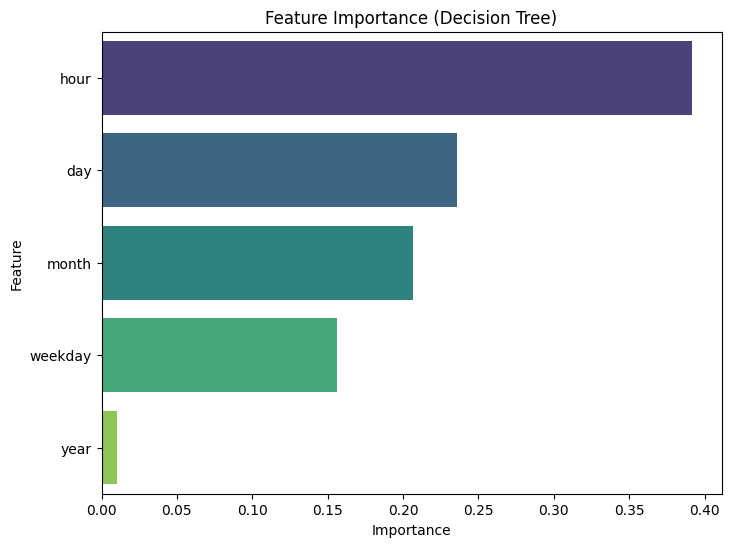

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title("Feature Importance (Decision Tree)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [ ]:
# ----------------------------------------
# Model Training Function for All Features
# ----------------------------------------
def train_all_models(data):
    """Train Linear Regression and Decision Tree for all features and save them."""
    date_info = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%m/%d/%Y %H:%M:%S')
    data['year'] = date_info.dt.year
    data['month'] = date_info.dt.month
    data['day'] = date_info.dt.day
    data['hour'] = date_info.dt.hour
    data['weekday'] = date_info.dt.weekday
    data = data.drop(['Date', 'Time'], axis=1)

    target_columns = [
        'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
        'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
        'T', 'RH', 'AH'
    ]

    for target in target_columns:
        print(f"\n🔧 Training models for: {target}")
        X = data[['year', 'month', 'day', 'hour', 'weekday']]
        y = data[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Linear Regression
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        r2_lr = r2_score(y_test, lr_model.predict(X_test))

        # Decision Tree
        dt_model = DecisionTreeRegressor(random_state=42)
        dt_model.fit(X_train, y_train)
        r2_dt = r2_score(y_test, dt_model.predict(X_test))

        print(f"   ➤ R² (Linear): {r2_lr:.3f}, R² (Decision Tree): {r2_dt:.3f}")

        # Save both models
        target_clean = target.replace("/", "_")
        with open(f'{target_clean}_lr_model.pkl', 'wb') as f:
            pickle.dump(lr_model, f)
        with open(f'{target_clean}_dt_model.pkl', 'wb') as f:
            pickle.dump(dt_model, f)

    print("\n✅ All models trained and saved!")

In [ ]:
# Train models
train_all_models(air_quality_data.copy())


🔧 Training models for: CO(GT)
   ➤ R² (Linear): 0.150, R² (Decision Tree): 0.590

🔧 Training models for: PT08.S1(CO)
   ➤ R² (Linear): 0.124, R² (Decision Tree): 0.644

🔧 Training models for: NMHC(GT)
   ➤ R² (Linear): 0.008, R² (Decision Tree): 0.518

🔧 Training models for: C6H6(GT)
   ➤ R² (Linear): 0.177, R² (Decision Tree): 0.587

🔧 Training models for: PT08.S2(NMHC)
   ➤ R² (Linear): 0.207, R² (Decision Tree): 0.641

🔧 Training models for: NOx(GT)
   ➤ R² (Linear): 0.241, R² (Decision Tree): 0.770

🔧 Training models for: PT08.S3(NOx)
   ➤ R² (Linear): 0.186, R² (Decision Tree): 0.713

🔧 Training models for: NO2(GT)
   ➤ R² (Linear): 0.269, R² (Decision Tree): 0.699

🔧 Training models for: PT08.S4(NO2)
   ➤ R² (Linear): 0.357, R² (Decision Tree): 0.825

🔧 Training models for: PT08.S5(O3)
   ➤ R² (Linear): 0.091, R² (Decision Tree): 0.686

🔧 Training models for: T
   ➤ R² (Linear): 0.302, R² (Decision Tree): 0.966

🔧 Training models for: RH
   ➤ R² (Linear): 0.136, R² (Decision Tre

In [ ]:
# ----------------------------------------
# Air Quality Assessment Logic
# ----------------------------------------
def assess_air_quality(pollutant, value):
    if 'CO' in pollutant:
        if value <= 4.4: return 'Good', 0
        elif value <= 9.4: return 'Moderate', 1
        else: return 'Poor', 2
    elif 'NO2' in pollutant:
        if value <= 53: return 'Good', 0
        elif value <= 100: return 'Moderate', 1
        else: return 'Poor', 2
    elif 'O3' in pollutant:
        if value <= 54: return 'Good', 0
        elif value <= 70: return 'Moderate', 1
        else: return 'Poor', 2
    return 'N/A', -1

In [ ]:
# ----------------------------------------
# Unified Prediction and Assessment
# ----------------------------------------
def unified_air_quality_predictor(models_dir='.', features=None):
    if features is None:
        features = ['year', 'month', 'day', 'hour', 'weekday']

    print("\n📥 Enter Input Values for Prediction:")
    year = int(input("Year: "))
    month = int(input("Month: "))
    day = int(input("Day: "))
    hour = int(input("Hour: "))
    weekday = int(input("Weekday (0=Mon ... 6=Sun): "))

    input_df = pd.DataFrame([[year, month, day, hour, weekday]], columns=features)

    assess_targets = ['CO(GT)', 'NO2(GT)', 'PT08.S5(O3)']
    status_scores = []

    print("\n🔮 Predictions:")
    for model_file in os.listdir(models_dir):
        if model_file.endswith(".pkl"):
            model_type = "Linear" if "_lr_" in model_file or "_lr_model" in model_file else "DecisionTree"
            target = model_file.replace("_lr_model.pkl", "").replace("_dt_model.pkl", "").replace("_", "/")
            try:
                with open(os.path.join(models_dir, model_file), 'rb') as f:
                    model = pickle.load(f)
                    pred = model.predict(input_df)[0]
                    print(f"{target} ({model_type}): {pred:.2f}")

                    # Assess air quality
                    if target in assess_targets:
                        status, score = assess_air_quality(target, pred)
                        print(f" ➤ Air Quality from {target}: {status}")
                        status_scores.append(score)
            except Exception as e:
                print(f"⚠️ Error loading {model_file}: {e}")

    if status_scores:
        avg_score = sum(status_scores) / len(status_scores)
        if avg_score <= 0.5:
            overall = '✅ Overall Air Quality: Good'
        elif avg_score <= 1.5:
            overall = '⚠️ Overall Air Quality: Moderate'
        else:
            overall = '❌ Overall Air Quality: Poor'
        print("\n" + overall)

In [ ]:
# ----------------------------------------
# Run Predictor
# ----------------------------------------
unified_air_quality_predictor()


📥 Enter Input Values for Prediction:
